# Intro

This notebook presents methods for solving __regression problems__.

A _regression problem_ is a problem where one wants to model a function whose image (or outputs, or labels) lies in an infinite continuous set, such as the real line $\mathbb{R}$ or the real plane $\mathbb{R}^2$.  The particular function that will be modeled in this notebook is the real-valued function $x^2$.  Since this function is not a linear one, this problem is said to be a _non-linear regression problem_.

The structure of this notebook if the following.  We begin by generating the dataset that will be used in the regression problem.  Then, we proceed to model the quadratic function $x^2$. Namely, we initialize a _random forest_ model, tune its hyperparameters (using _grid search_), and evaluate its accuracy.  Then, we also initialize a _gradient boosting_ model, tune its hyperparameters (using a _randomized search_ and a _grid search_), and evaluate its accuracy.  After that, we are able to draw a few conclusions from the results that we obtained.  Lastly, in the appendix, we list a few other methods that could have been used to solve this problem.

# Data set

<a name="constructing-the-data-set"></a>
## Constructing the data set

In [4]:
from random import uniform


# Choose the size of the data set.
s = 1000

# Construct a list of random numbers between 0 and 1.  These numbers are
# called the 'features' of the regression problem.
features = [uniform(-1, 1) for _ in range(s)]

# To construct the list of 'labels', that is, the image of the 'features',
# we will define a function.  This function is, essentially, the quadratic
# one (x -> x^2), except for an added noise.  This noise can be interpreted
# as measurement errors of an experiment, for instance.
def f(x : float) -> float:
    noise = uniform(-0.1, 0.1)
    return x**2 + noise

# Using the function f (above), construct the 'labels' list.
labels = [f(x) for x in features]


## Plotting the data

To visualize the data that was constructed above, we will plot the pairs feature-label in the real plane $\mathbb{R}^2$.

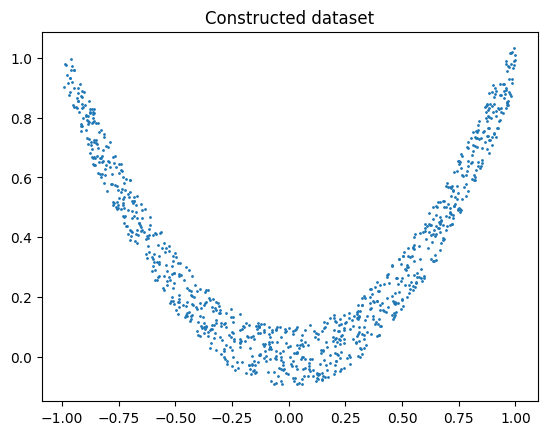

In [5]:
import matplotlib.pyplot as plt


# Plot the features in the x-axis, the labels in the y-axis, and set the size
# of the point markers to 1pt (to make it easier to see the points).
plt.title("Constructed dataset")
plt.scatter(features, labels, s=1)
plt.show()


## Splitting the data

The last step before training the models will be the splitting of the dataset (constructed above) into _training_ and _test_ subsets.  The _training subset_ will be used in the training phase, and the _test subset_ will be used in the evaluation phase.

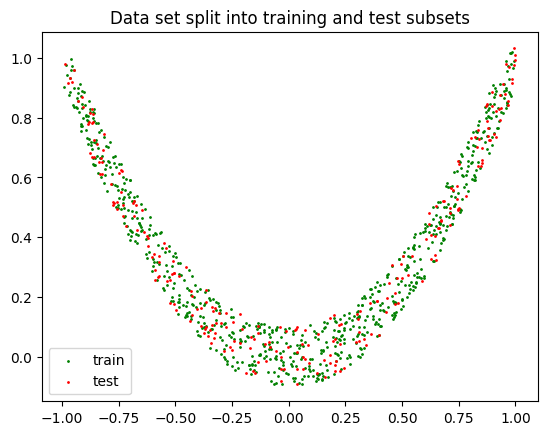

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


# Separate the dataset into training and testing subsets.
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state=1)

# Technical trick: reshape the training and testing features to avoid errors
# in the training and evaluation phases.
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1,1)

# To visualize the diferent subsets, we will plot the points of the training
# set in green and the points of the test set in red.
plt.scatter(X_train, Y_train, s=1, c='green', label="train")
plt.scatter(X_test, Y_test, s=1, c='red', label="test")

# Show the graph.
plt.title("Data set split into training and test subsets")
plt.legend()
plt.show()


# Training the models

In this section, we will train two models: a decision tree and a gradient boosting.  Even though these are not the only models that can be used to solve a non-linear regression problem (see the [appendix](#appendix)), they enable us to present the process of training, tuning (the hyperparameters) and evaluating the model.

## Decision tree

In [5]:
# Decision tree
from sklearn import tree

decision_tree = tree.DecisionTreeRegressor()


In [8]:
# Tune the hyperparameters:
from sklearn.model_selection import GridSearchCV


## Create a dictionary listing all the parameters that will be tested.
parameters = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
              'splitter': ["best", "random"],
              'min_samples_split': range(2, 11),
              'min_samples_leaf': range(1, 11),
              'max_depth': range(1, 11)
}

## Perform an exhaustive test through all the parameters.
grid_search = GridSearchCV(decision_tree, parameters).fit(X_train, Y_train)

## Print the best option.
## Be careful: the best result may lead to overfitting!
print(grid_search.best_estimator_)


DecisionTreeRegressor(max_depth=8, min_samples_leaf=9)


In [9]:
# Set the hyperparameters of the model to the best ones found above, and then
# train (fit) the corresponding model using the train data subset.

decision_tree = tree.DecisionTreeRegressor(max_depth=8, min_samples_leaf=9)
fitted_decision_tree = decision_tree.fit(X_train, Y_train)


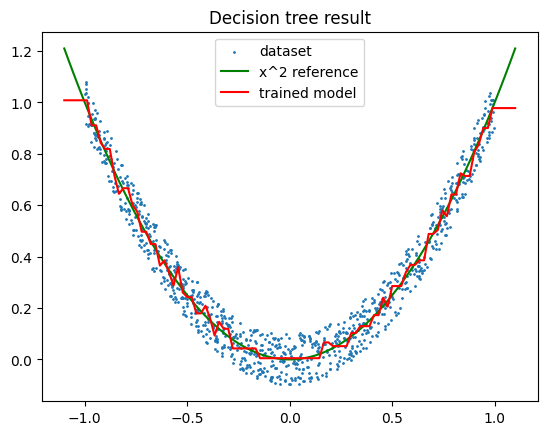

In [10]:
# Plot the trained model as a function:
import numpy as np


## For the x-axis, construct a grid of 100 points in the interval [-1.1, 1.1].
T = np.linspace(-1.1, 1.1, 100)
## For the y-axis, first construct the x^2 function, as a reference.
F = [t**2 for t in T]
## Then, also construct the result of the decision tree training.
G = [fitted_decision_tree.predict([[t]]) for t in T]

## Plot the dataset.
plt.scatter(features, labels, s=1, label='dataset')
## Plot the (x, x^2) points in green, as a reference.
plt.plot(T, F, color='green', label='x^2 reference')
## Plot the result of the decision tree in red.
plt.plot(T, G, color='red', label='trained model')
## Show the graph.
plt.title("Decision tree result")
plt.legend()
plt.show()


In [11]:
# Evaluate the model:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Predict the image of the 'features' from the test subset, using the trained
## and tunned model.
Y_predicted = fitted_decision_tree.predict(X_test)

## Calculate its R2 score.
r2s_test = r2_score(Y_test, Y_predicted)

## Calculate its mean absolute error.
mae_test = mean_absolute_error(Y_test, Y_predicted)

## Calculate its mean squared error.
mse_test = mean_squared_error(Y_test, Y_predicted)


## Predict the image of the 'features' from the train subset, to check if the
## trained and tunned model is overfitting.
Y_eval = fitted_decision_tree.predict(X_train)

## Calculate its R2 score.
r2s_train = r2_score(Y_train, Y_eval)

## Calculate its mean absolute error.
mae_train = mean_absolute_error(Y_train, Y_eval)

## Calculate its mean squared error.
mse_train = mean_squared_error(Y_train, Y_eval)


## Print the results.
print(f"R2: {r2s_test} (test), {r2s_train} (train)")
print(f"MAE: {mae_test} (test), {mae_train} (train)")
print(f"MSE: {mse_test} (test), {mse_train} (train)")


R2: 0.9529404611071531 (test), 0.9691921532499668 (train)
MAE: 0.053134946470057745 (test), 0.044338738176815884 (train)
MSE: 0.003949185634986688 (test), 0.0027965263539278685 (train)


Since the $\text R^2$ score of the tunned decision tree model on the test data subset is high (close to 1) and its mean absolute and squared errors are low (close to 0), this method is having a good accuracy.  Moreover, since its $\text R^2$ score, mean absolute and squared errors on the test and train data subsets are similar (and different from 1 and 0), we can also see that the tunned model is not overfitting.


## Gradient boosting

In [7]:
# Gradient Boosting
from sklearn import ensemble

gradient_boosting = ensemble.GradientBoostingRegressor()


In [8]:
# Tune the hyperparameters (part I):
from sklearn.model_selection import RandomizedSearchCV


## Begin with a randomized search in a large set of parameters.
parameters = {'criterion': ["friedman_mse", "squared_error"],
              'loss': ["squared_error", "absolute_error", "huber", "quantile"],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.9],
              'max_depth': range(3, 50),
              'min_samples_leaf': range(1, 50),
              'min_samples_split': range(2, 50),
              'n_estimators': range(0, 100)
}

## Perform a randomized search through these parameters.
random_search = RandomizedSearchCV(gradient_boosting, parameters).fit(X_train, Y_train)

## Print the best option.
print(random_search.best_estimator_)


GradientBoostingRegressor(criterion='squared_error', learning_rate=0.2,
                          loss='huber', max_depth=16, min_samples_leaf=31,
                          min_samples_split=12, n_estimators=14)


In [11]:
# Tune the hyperparameters (part II):
from sklearn.model_selection import GridSearchCV


## Now, we use the results of the randomized search above to do an exhaustive
## search.  Create a more localized dictionary listing the parameters that
## will be exhautively tested.
parameters = {'criterion': ["squared_error"],
              'loss': ["huber"],
              'learning_rate': [0.15, 0.2, 0.3, 0.4, 0.45],
              'n_estimators': range(12, 17),
              'max_depth': range(14, 19),
              'min_samples_leaf': range(29, 34),
              'min_samples_split': range(10, 15),
}

## Perform an exhaustive search through all these parameters.
grid_search = GridSearchCV(gradient_boosting, parameters).fit(X_train, Y_train)

## Print the best option.
print(grid_search.best_estimator_)


GradientBoostingRegressor(criterion='squared_error', learning_rate=0.3,
                          loss='huber', max_depth=14, min_samples_leaf=30,
                          min_samples_split=10, n_estimators=13)


In [13]:
# Set the hyperparameters of the model to the best ones found above.

gradient_boosting = ensemble.GradientBoostingRegressor(criterion='squared_error', learning_rate=0.3, loss='huber', max_depth=14, min_samples_leaf=30, min_samples_split=10, n_estimators=13)
fitted_gradient_boosting = gradient_boosting.fit(X_train, Y_train)


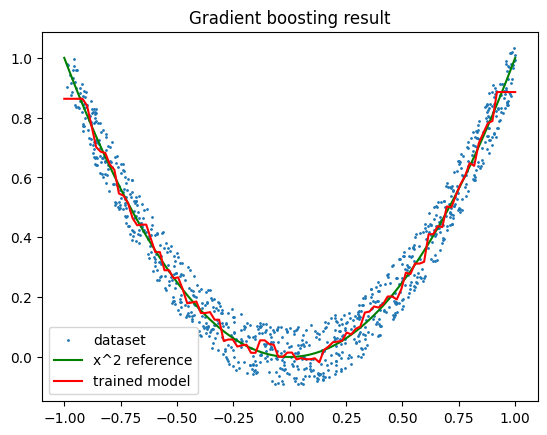

In [15]:
# Plot the trained model as a function:
import numpy as np


## For the x-axis, construct a grid of 100 points in the interval [-1.1, 1.1].
T = np.linspace(-1, 1, 100)
## For the y-axis, first construct the x^2 function, as a reference.
F = [t**2 for t in T]
## Then, also construct the result of the gradient boosting training.
G = [fitted_gradient_boosting.predict([[t]]) for t in T]


## Plot the dataset.
plt.scatter(features, labels, s=1, label='dataset')
## Plot the (x, x^2) points in green, as a reference.
plt.plot(T, F, color='green', label='x^2 reference')
## Plot the result of the gradient boosting in red.
plt.plot(T, G, color='red', label='trained model')
## Show the graph.
plt.title("Gradient boosting result")
plt.legend()
plt.show()


In [16]:
# Evaluate the model:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Predict the image of the 'features' from the test subset, using the trained
## and tunned gradient boosting model.
Y_predicted = fitted_gradient_boosting.predict(X_test)

## Calculate its R2 score.
r2s_test = r2_score(Y_test, Y_predicted)

## Calculate its mean absolute error.
mae_test = mean_absolute_error(Y_test, Y_predicted)

## Calculate its mean squared error.
mse_test = mean_squared_error(Y_test, Y_predicted)


## Predict the image of the 'features' from the train subset, to check if the
## trained and tunned gradient boosting model is overfitting.
Y_eval = fitted_gradient_boosting.predict(X_train)

## Calculate its R2 score.
r2s_train = r2_score(Y_train, Y_eval)

## Calculate its mean absolute error.
mae_train = mean_absolute_error(Y_train, Y_eval)

## Calculate its mean squared error.
mse_train = mean_squared_error(Y_train, Y_eval)


## Print the results.
print(f"R2: {r2s_test} (test), {r2s_train} (train)")
print(f"MAE: {mae_test} (test), {mae_train} (train)")
print(f"MSE: {mse_test} (test), {mse_train} (train)")


R2: 0.9604097032344804 (test), 0.967349231258476 (train)
MAE: 0.05195518959105629 (test), 0.046211702341521554 (train)
MSE: 0.0038099958369349264 (test), 0.0029506331498873805 (train)


Since the $\text R^2$ score of the tunned gradient boosting model on the test data subset is high (close to 1) and its mean absolute and squared errors are low (close to 0), this method is also having a good accuracy.  Moreover, since its $\text R^2$ score, mean absolute and squared errors on the test and train data subsets are similar (and different from 1 and 0), we can also see that this tunned model is also not overfitting.

# Conclusions

The function $x^2$ is clearly a very simple function, but a good testing example for the regression methods that were implemented.  Notice that, by changing the definition of $f$ in the <a href="#constructing-the-data-set">construction of the data set</a> and running the subsequent cells, one can experiment with different functions.

Now, regarding the results obtained for the function $x^2$, one can see that `Gradient boosting` is more accurate, while `Decision trees` is faster to train and easier to tune.  It is also worth noticing that `Decision trees` is very prone to overfitting.  Thus, one must pay close attention to the tuning of this method.

Finally, notice that `Decision trees` and `Gradient boosting` are not able to provide __any__ information about the values of the function $x^2$ outside the interval in which they were trained, $[-1, 1]$.  It would be interesting to find out whether it is possible to train a model in such a way that it gives better estimates for the values of $x^2$ outside the interval $[-1, 1]$.

<a name='appendix'></a>
# Appendix

A list of models that can be used to solve regression problems.

Gaussian process: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

regressor = GaussianProcessRegressor()


Nearest neighbors:  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()


Random forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [ ]:
from sklearn import ensemble

regressor = ensemble.RandomForestRegressor()


Support vector machines: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

In [ ]:
from sklearn import svm

regressor = svm.SVR()
